In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import json
import numpy as np
import os
import time
import glob
import pandas as pd
import matplotlib.pyplot as plt

from model import efficientdet
from utils import preprocess_image, postprocess_boxes
from utils.draw_boxes import draw_boxes

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

phi = 0
weighted_bifpn = False
num_angles = 4
num_anchors = 9
model_path = './gbb_cow.h5'
path_images = '/datasets/dataset/coco2017/train2017'
path_csv = '/datasets/dataset/coco2017/annotations/instances_train2017_obb_cow.csv'
path_classes = './classes_cow.csv'

In [4]:
image_sizes = (512, 640, 768, 896, 1024, 1280, 1408)
image_size = image_sizes[phi]

# coco classes
df_classes = pd.read_csv(path_classes)
classes = dict(zip(df_classes['id'], df_classes['name']))
num_classes = len(classes)+1
score_threshold = 0.1
colors = [np.random.randint(0, 256, 3).tolist() for _ in range(num_classes)]

model, inf_model = efficientdet(phi=phi,
                        weighted_bifpn=weighted_bifpn,
                        num_classes=num_classes,
                        score_threshold=score_threshold,
                        num_angles=num_angles,
                        num_anchors=num_anchors)
#model.load_weights(model_path, by_name=True)
inf_model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead


In [5]:
df = pd.read_csv(path_csv)
df['file_name'] = path_images + '/' + df['file_name']

In [6]:
image_path = np.random.choice(df['file_name'])

image = cv2.imread(image_path)
image_height, image_width = image.shape[:2]
        
sh = image_size / image_height
sw = image_size / image_width

src_image = cv2.resize(image.copy(), (image_size,image_size))
# BGR -> RGB
image = image[:, :, ::-1]
h, w = image.shape[:2]

image, scale = preprocess_image(image, image_size=image_size)
# run network
start = time.time()
boxes, scores, labels = inf_model.predict_on_batch([np.expand_dims(image, axis=0)])

boxes, scores, labels = np.squeeze(boxes), np.squeeze(scores), np.squeeze(labels)
print(time.time() - start)

2.316922903060913


In [7]:
boxes = postprocess_boxes(boxes=boxes, scale=1, height=h, width=w)

# select indices which have a score above the threshold
indices = np.where(scores[:] > score_threshold)[0]

# select those detections
boxes  = boxes[indices]
labels = labels[indices]

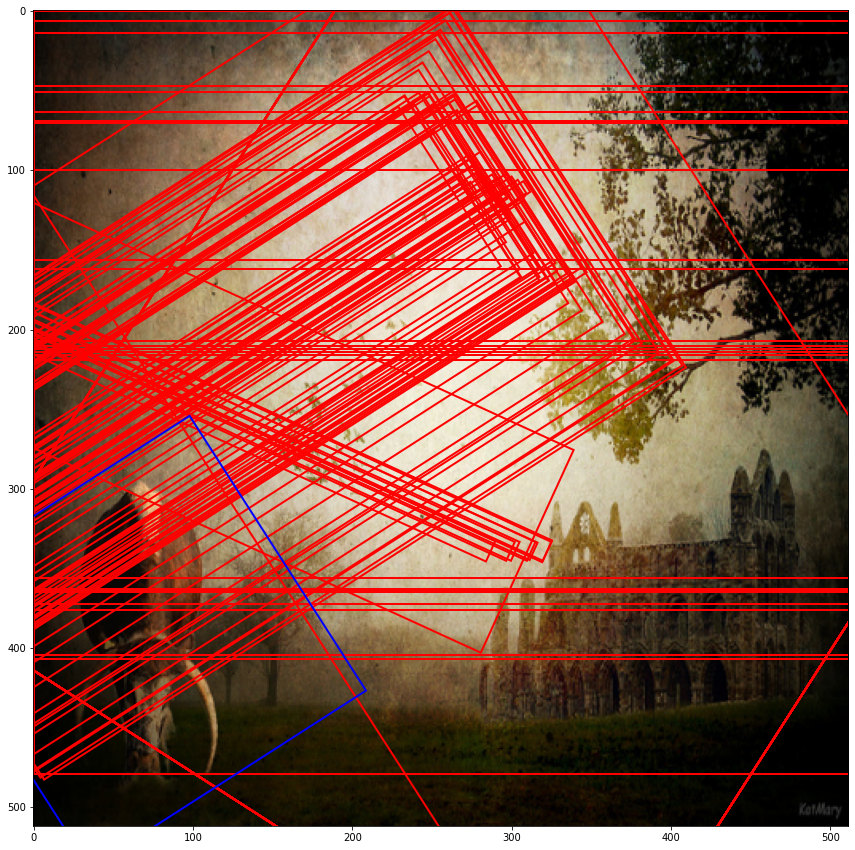

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(src_image[:,:,::-1])
current_axis = plt.gca()

for b in boxes:
    xmin, ymin, xmax, ymax, angle = list(map(int, b))
    cx = (xmax+xmin)/2; cy = (ymax+ymin)/2
    w = (xmax-xmin); h = (ymax-ymin)
    #angle = np.arctan((sh/sw)*np.tan(angle))
    
    xmin = cx - 1 / 2 * (-h * np.sin(angle) + w * np.cos(angle))
    ymin = cy - 1 / 2 * (h * np.cos(angle) + w * np.sin(angle))
    
    current_axis.add_patch(
        plt.Rectangle((xmin, ymin), w, h, angle=angle * 180 / np.pi, color='red', fill=False, linewidth=2)
    )
    
targets = np.stack([df[df['file_name']==image_path][col] for col in ('x1','y1','x2','y2','angle')], axis=-1)
for b in targets:
    xmin, ymin, xmax, ymax, angle = list(map(int, b))
    cx = (xmax+xmin)/2; cy = (ymax+ymin)/2
    w = (xmax-xmin); h = (ymax-ymin)
    #angle = np.arctan((sh/sw)*np.tan(angle))
    
    xmin = cx - 1 / 2 * (-h * np.sin(angle) + w * np.cos(angle))
    ymin = cy - 1 / 2 * (h * np.cos(angle) + w * np.sin(angle))
    
    current_axis.add_patch(
        plt.Rectangle((xmin, ymin), w, h, angle=angle * 180 / np.pi, color='blue', fill=False, linewidth=2)
    )